In [1]:
# STEP 1: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

# STEP 2: Setup GPU & Speed Boost
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# STEP 3: Transforms (Augmentation + Normalization)
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


In [7]:
# STEP 4: Dataset (separate train and test folders)
train_dir = "Dataset/Training"
test_dir = "Dataset/Test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=test_dir, transform=val_transform)


In [8]:
# STEP 5: Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [9]:
# STEP 6: Load ResNet18 and Modify
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, len(train_dataset.classes))  # auto-detect classes
)
model = model.to(device)


c:\Users\Jatin bagga\Desktop\FOOD_SPOILAGE_IR\food\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jatin bagga\Desktop\FOOD_SPOILAGE_IR\food\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# STEP 7: Loss, Optimizer & Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [11]:
# STEP 8: Training Loop with Metrics
num_epochs = 20
start = time.time()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"🔹 Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"🔸 Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.2f}%\n")

    scheduler.step()

print(f"\n✅ Training Time: {(time.time() - start)/60:.2f} minutes")


Epoch [1/20]
🔹 Train Loss: 0.4596 | Train Acc: 87.06%
🔸 Val Loss:   0.2690 | Val Acc:   91.62%

Epoch [2/20]
🔹 Train Loss: 0.1596 | Train Acc: 94.82%
🔸 Val Loss:   0.2865 | Val Acc:   91.57%

Epoch [3/20]
🔹 Train Loss: 0.1110 | Train Acc: 96.19%
🔸 Val Loss:   0.3087 | Val Acc:   92.45%

Epoch [4/20]
🔹 Train Loss: 0.0903 | Train Acc: 96.76%
🔸 Val Loss:   0.2650 | Val Acc:   93.20%

Epoch [5/20]
🔹 Train Loss: 0.0742 | Train Acc: 97.20%
🔸 Val Loss:   0.2593 | Val Acc:   93.58%

Epoch [6/20]
🔹 Train Loss: 0.0485 | Train Acc: 98.08%
🔸 Val Loss:   0.2345 | Val Acc:   94.04%

Epoch [7/20]
🔹 Train Loss: 0.0429 | Train Acc: 98.21%
🔸 Val Loss:   0.2599 | Val Acc:   94.12%

Epoch [8/20]
🔹 Train Loss: 0.0399 | Train Acc: 98.31%
🔸 Val Loss:   0.2672 | Val Acc:   93.76%

Epoch [9/20]
🔹 Train Loss: 0.0382 | Train Acc: 98.33%
🔸 Val Loss:   0.3136 | Val Acc:   91.87%

Epoch [10/20]
🔹 Train Loss: 0.0334 | Train Acc: 98.52%
🔸 Val Loss:   0.2906 | Val Acc:   93.37%

Epoch [11/20]
🔹 Train Loss: 0.0283 | Tr

In [12]:
# STEP 9: Save Model
torch.save(model.state_dict(), "optimized_resnet.pth")
print("💾 Model saved as resnet18_dataset_split_trained.pth")


💾 Model saved as resnet18_dataset_split_trained.pth


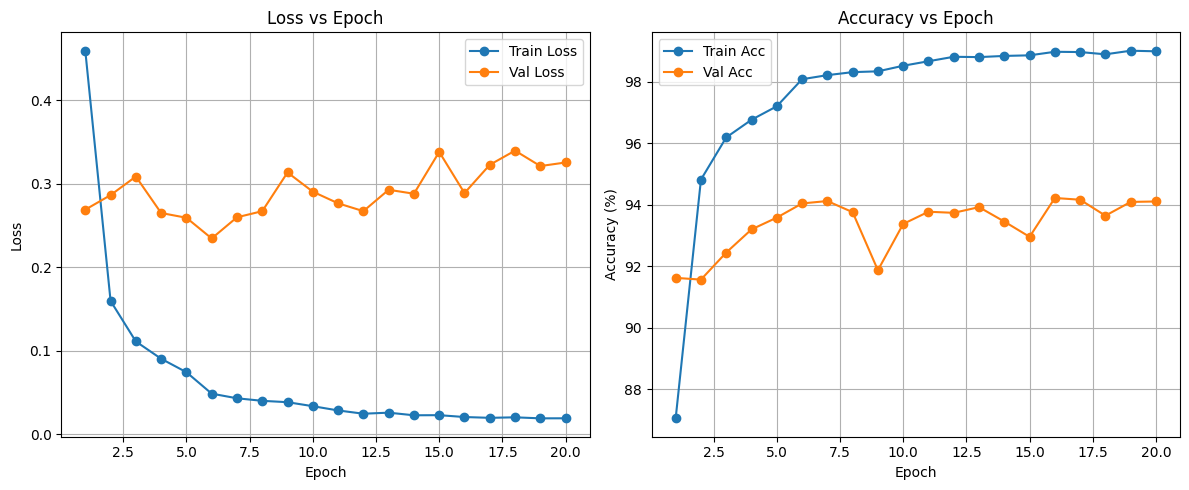

In [13]:
# STEP 10: Plot Loss & Accuracy Curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc', marker='o')
plt.plot(epochs, val_accuracies, label='Val Acc', marker='o')
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
import torch
import torch.nn as nn
from torchvision import models

# Class list from your project (26 categories in your case)
class_names = ['FreshApple', 'FreshBanana', 'FreshBellpepper', 'FreshBittergroud', 'FreshCapsicum', 'FreshCarrot', 'FreshCucumber', 'FreshMango', 'FreshOkra', 'FreshOrange', 'FreshPotato', 'FreshStrawberry', 'FreshTomato',
               'RottenApple', 'RottenBanana', 'RottenBellpepper', 'RottenBittergroud', 'RottenCapsicum', 'RottenCarrot', 'RottenCucumber', 'RottenMango', 'RottenOkra', 'RottenOrange', 'RottenPotato', 'RottenStrawberry', 'RottenTomato']

# ✅ Step 2: Recreate the model exactly as trained
model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, len(class_names))  # 26 classes
)

# ✅ Step 3: Load the trained weights
model.load_state_dict(torch.load("best_resnet18_model.pth", map_location='cpu'))
model.eval()

c:\Users\Jatin bagga\Desktop\FOOD_SPOILAGE_IR\food\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jatin bagga\Desktop\FOOD_SPOILAGE_IR\food\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
example = torch.rand(1, 3, 128, 128)
traced_model = torch.jit.trace(model, example)
traced_model.save("resnet18_traced.pt")